# Experiment: Water Management Strategies: Water Treatment



In [13]:
import os
import sys

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

from src.aquastat_utils import *

# Import AQUASTAT
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import scipy.stats as stats

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 300})

### Check available Data for inconsistencies
There are multiple municipal wastewater variables. To check their consistencies we should check if they correspond to one another.

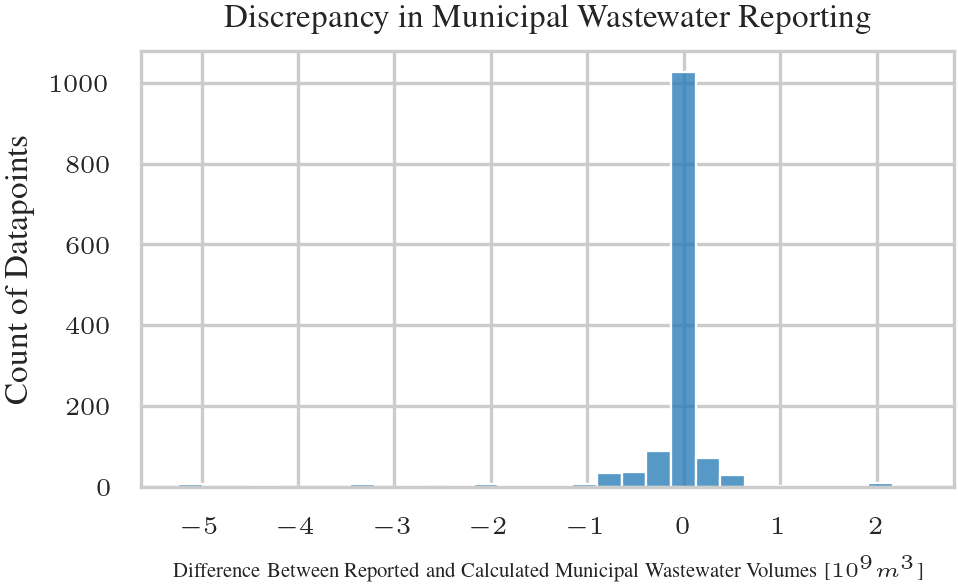

In [15]:
test_df = aquastat_df[['Country', 'Year', 'Treated municipal wastewater', 'Not treated municipal wastewater',
                       'Produced municipal wastewater']].dropna()

test_df['Difference'] = test_df['Produced municipal wastewater'] - (
            test_df['Treated municipal wastewater'] + test_df['Not treated municipal wastewater'])

sns.histplot(data=test_df, x='Difference', bins=30)
plt.title('Discrepancy in Municipal Wastewater Reporting')
plt.xlabel('Difference Between Reported and Calculated Municipal Wastewater Volumes [$10^9 m^3$]', fontsize='5')
plt.ylabel('Count of Datapoints')
plt.show()

For the overwhelming majority of the dataset the sum of treated and non-treated municipal wastewater is very close to the produced municipal wastewater.

### Examine treated municiple water share

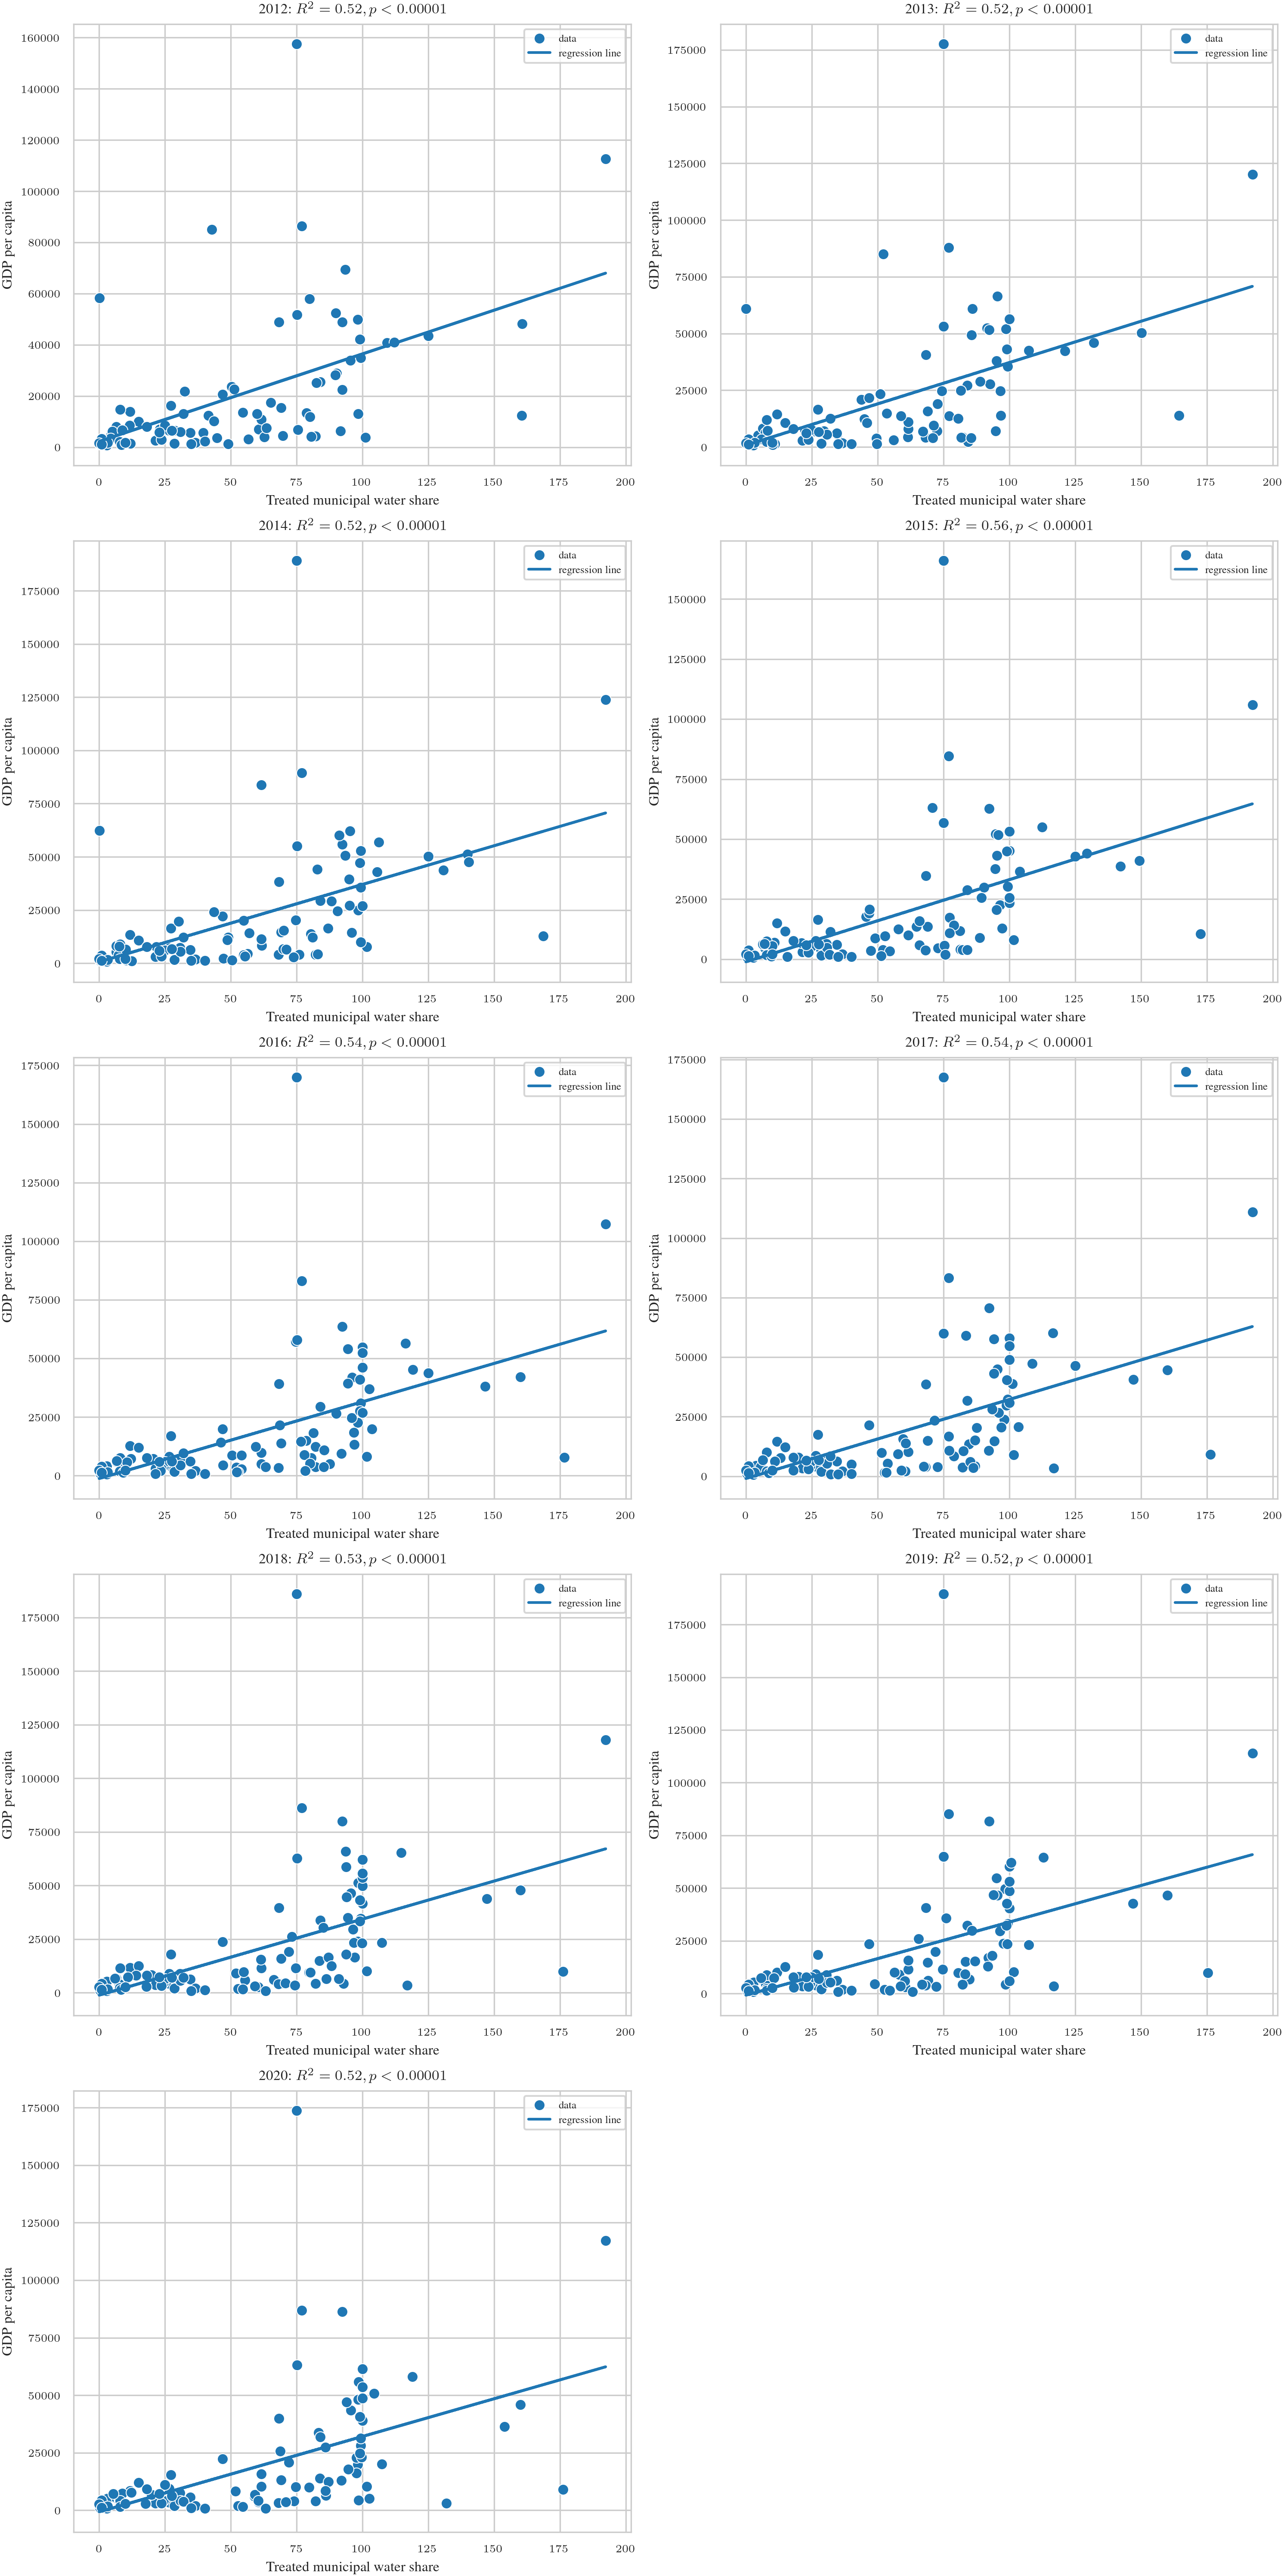

In [16]:
wastewater_df = aquastat_df[
    ['Country', 'Year', 'Treated municipal wastewater', 'Produced municipal wastewater']].dropna()
wastewater_df['Treated municipal water share'] = (wastewater_df['Treated municipal wastewater'] / wastewater_df[
    'Produced municipal wastewater']) * 100
wastewater_df = wastewater_df[wastewater_df['Treated municipal water share'] < 200]

regression_var = 'GDP per capita'
wastewater_df[regression_var] = aquastat_df[regression_var]
wastewater_df = wastewater_df.dropna()

start = 2012
years = wastewater_df[wastewater_df['Year'] >= 2012]['Year'].unique()
years.sort()
n = len(years)
width = min(2, n)
height = math.ceil(n / width)

fig, axes = plt.subplots(height, width, figsize=(5 * width, 4 * height))
for i, year in enumerate(years):
    ax = axes[i // width, i % width]
    data = wastewater_df[wastewater_df['Year'] == year]
    sns.scatterplot(
        ax=axes[i // width, i % width],
        data=data,
        x='Treated municipal water share',
        y=regression_var,
        label='data')

    x = data['Treated municipal water share'].values
    y = data[regression_var].values
    slope, intercept, r, p, _ = stats.linregress(x=x, y=y)
    ax.plot(x, slope * x + intercept, label='regression line')
    ax.legend()

    eq = '='
    if p < 0.00001:
        eq = '<'
        p = 0.00001

    ax.set_title(f'{year}: $R^2 = {r:.2f}, p {eq} {p:.5f}$')

for i in range(n, width * height):
    axes[i // width, i % width].axis('off')

### Plot water treatment

Text(0.95, 0.01, 'Source: [Your Data Source Here]')

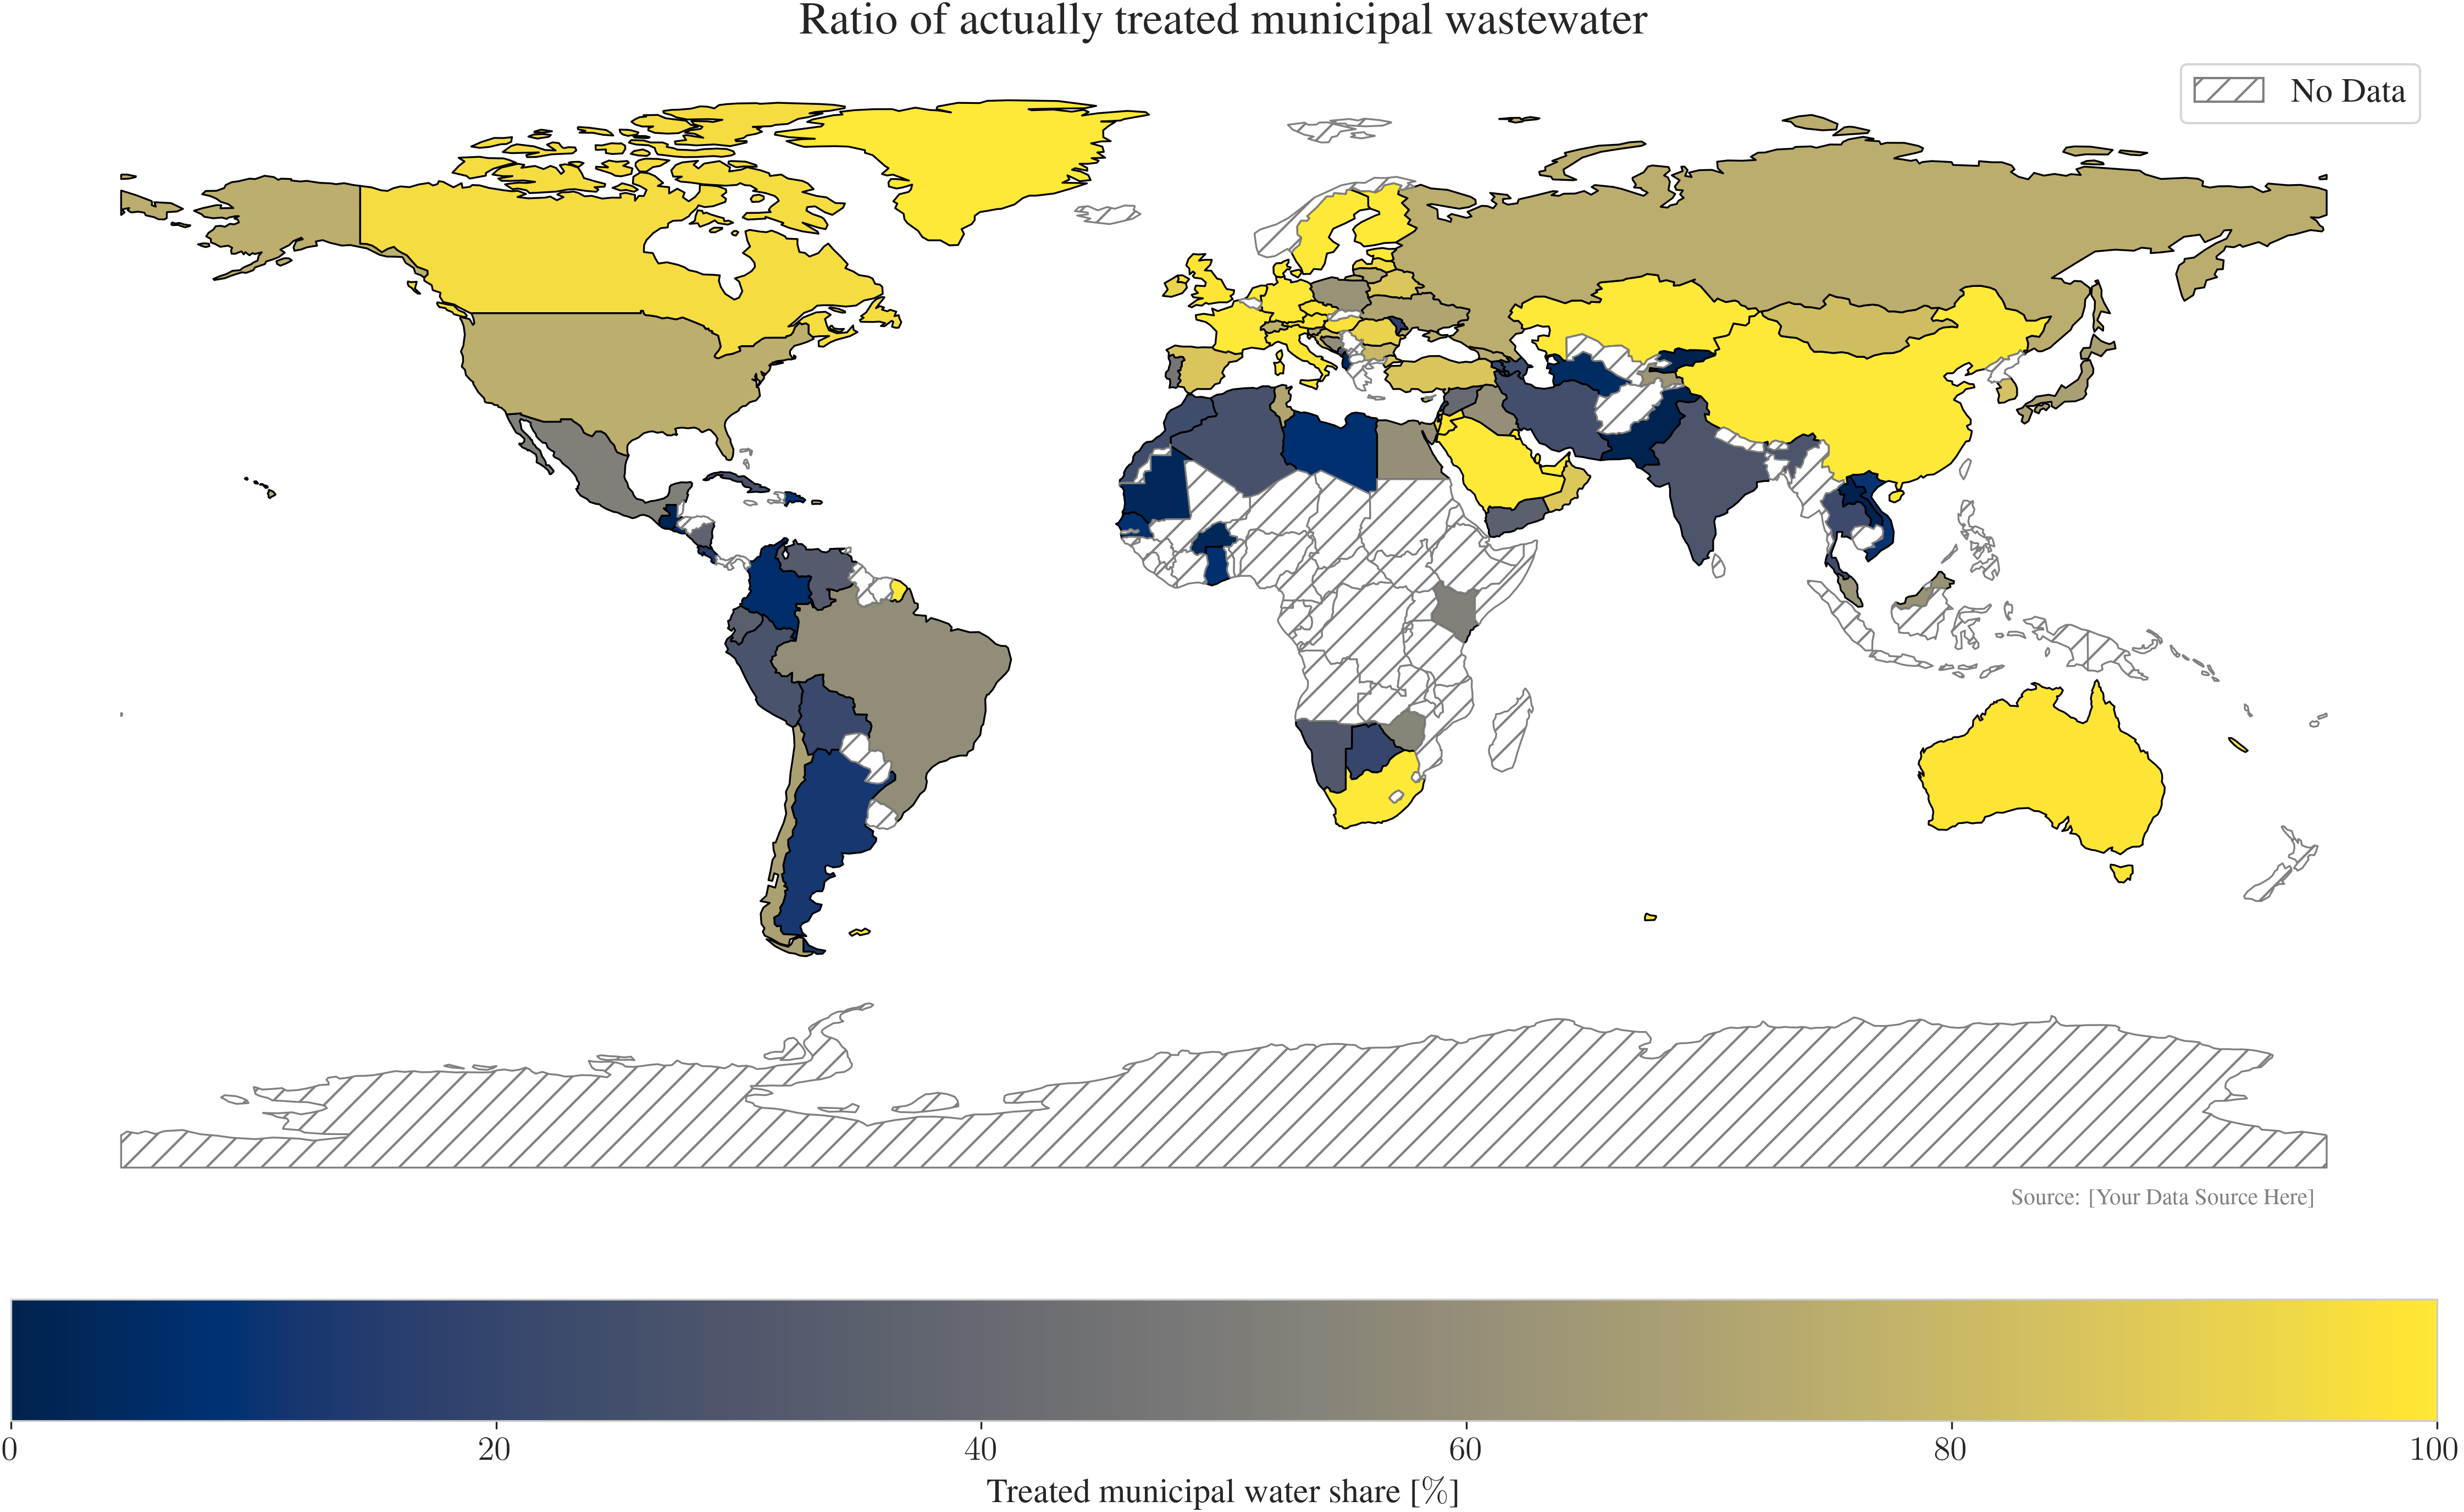

In [17]:
# Get map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
# Join Data to map
merged = world.set_index('SOVEREIGNT').join(wastewater_df[wastewater_df['Year'] == 2020].set_index('Country'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotting
merged.plot(
    column='Treated municipal water share',
    ax=ax, legend=True,
    missing_kwds={"color": "white", "edgecolor": "grey", "label": "No Data", "hatch": "//"},
    cmap='cividis',
    vmin=0, vmax=100,
    edgecolor='black',  # Add black borders for each country
    linewidth=0.8,  # Adjust line width of the borders
    legend_kwds={
        'label': "Treated municipal water share [%]",
        'orientation': "horizontal",
    }
)

# Change font sizes
cbar = fig.axes[-1]
cbar.set_xlabel('Treated municipal water share [$\%$]', fontsize=15)
for label in cbar.get_xticklabels():
    label.set_fontsize(15)

# Create a custom legend patch for "No Data"
no_data_patch = mpatches.Patch(edgecolor='grey', facecolor='white', label='No Data', hatch='//')
ax.legend(handles=[no_data_patch], loc='upper right', fontsize=15)

# Remove axis
ax.axis('off')

ax.set_title('Ratio of actually treated municipal wastewater', fontsize=20)

# Add source text
fig.text(0.95, 0.01, AQUASTAT_SOURCE,
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax.transAxes,
         color='grey', fontsize=10)

In [18]:
from src.aquastat_plot import plot_growth_rate

share_df = wastewater_df[['Treated municipal water share', 'Country', 'Year']].dropna()
share_df = share_df.pivot(index='Year', columns='Country', values='Treated municipal water share')
share_df = share_df.loc[2012:2020].dropna(axis=1)
share_df = share_df.reset_index().melt(id_vars='Year', var_name='Country', value_name='Treated municipal water share')
plot_growth_rate(share_df, 'Treated municipal water share')

ImportError: cannot import name 'AQUASTAT_SOURCE' from 'src.aquastat_utils' (/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/aquastat_utils.py)

### Check for connections to water stress

In [ ]:
a = wastewater_df[(wastewater_df['Year'] == 2020) & (wastewater_df['Water stress'] < 500) & (
            wastewater_df['Treated municipal water share'] <= 100)]

In [ ]:
wastewater_df['Water stress'] = aquastat_df['SDG 6.4.2. Water Stress']
wastewater_df = wastewater_df.dropna()
sns.scatterplot(data=a, x='Treated municipal water share', y='Water stress')